# Glühlampenspektrum

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class Glueh:
    def __init__(self,path):
        data = np.loadtxt(path).T
        self.steps = data[0]
        self.intensity = data[1]
        self.steps = self.steptowavelenght(self.steps)

    
    def steptowavelenght(self,step):
        step = np.array(step)
        return (7.05835870e-08*step**2 + 1.01924329e-03*step + 4.75424576e+02)

    def planck(self,A,B,T):
        # Wie rechne ich Schrittmotorschritte in Wellenlängen um
        return A/(np.exp(B)-1)

Spektrum mit Linse ist sehr hässlich, weshalb es nicht ausgewertet wird.

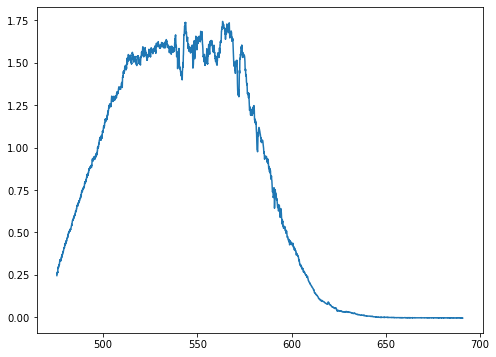

In [6]:
linse0 = Glueh('data/Gluehlampenspektrum/spek_linse_0.dat')
spek300 = Glueh('data/Gluehlampenspektrum/spek_-3_300.dat')
spek400 = Glueh('data/Gluehlampenspektrum/spek_-3_400.dat')
spek512 = Glueh('data/Gluehlampenspektrum/spek_-3_512.dat')
spek512_4 = Glueh('data/Gluehlampenspektrum/spek_-4_512.dat')



fig = plt.figure(figsize=(8,6))
plt.plot(linse0.steps,linse0.intensity)
#plt.plot(spek300.steps,spek300.intensity)
#plt.plot(spek400.steps,spek400.intensity)
#plt.plot(spek512.steps,spek512.intensity)
#plt.plot(spek512_4.steps,spek512_4.intensity)